<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/Mobius_Backtest_BTCUSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3135677771.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return [(float(precos[i]), float(precos[i+1])) for i in range(start, start+length)]
/tmp/ipython-input-3135677771.py:111: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  price = float(prices[idx_price])
/tmp/ipython-input-3135677771.py:130: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  final_value = cash + pos * float

Capital final: 1051.45 USD
ROI total: 5.15%
Win rate: 55.07%
Nº de trades (round-trips): 69


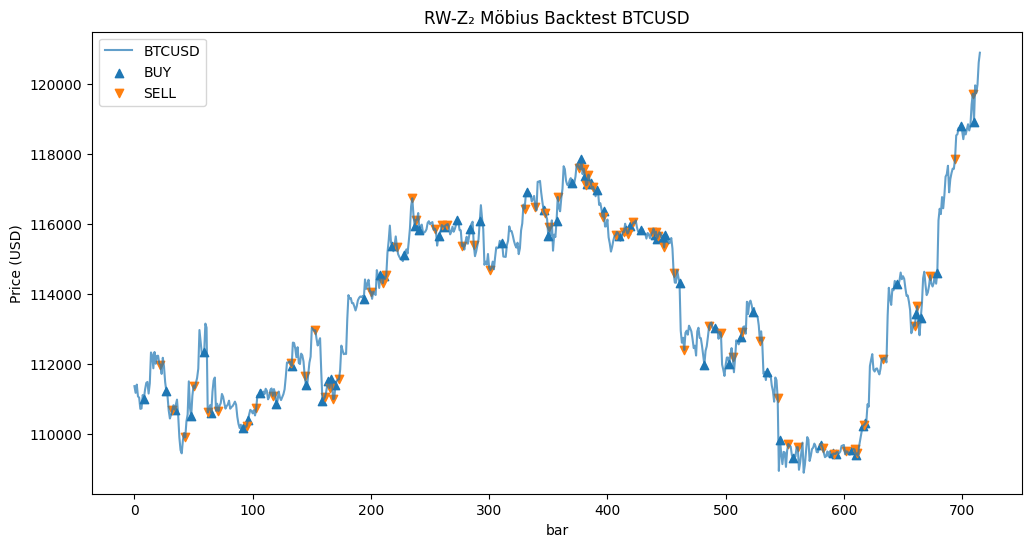

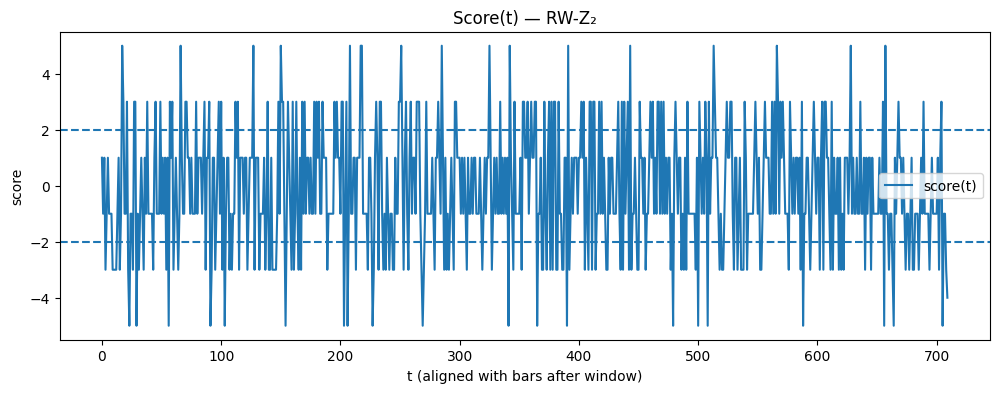

In [ ]:
# ==========================================
# RW-Z2 Möbius Backtest BTCUSD (robusto)
# ==========================================
!pip -q install yfinance --upgrade

import yfinance as yf
import numpy as np
import random
import math
import matplotlib.pyplot as plt

# -----------------------------
# 0. Configs
# -----------------------------
random.seed(42)
np.random.seed(42)

PAIR = "BTC-USD"
INTERVAL = "1h"   # "1m", "5m", "15m", "1h", "4h", "1d"
PERIOD   = "30d"  # "7d","30d","60d","1y"...

# -----------------------------
# 1. Baixar dados BTCUSD
#    (auto_adjust=False p/ manter OHLCV "crus")
# -----------------------------
df = yf.download(PAIR, interval=INTERVAL, period=PERIOD, auto_adjust=False)
if df is None or df.empty:
    raise RuntimeError("Sem dados baixados. Tente outro INTERVAL/PERIOD.")

prices = df["Close"].astype(float).to_numpy()
times  = np.arange(len(prices))

# -----------------------------
# 2. Funções RW-Z2
# -----------------------------
def gerar_ciclo(precos, start, length=3):
    """Gera um ciclo curto (lista de arestas) [(p_i, p_{i+1}), ...]."""
    if start + length >= len(precos):
        return None
    return [(float(precos[i]), float(precos[i+1])) for i in range(start, start+length)]

def sinais_arestas(ciclo, twist_prob=0.5):
    """Atribui g_e ∈ {+1,-1}; twist_prob controla frequência de -1."""
    out = []
    for _ in ciclo:
        g = -1 if random.random() < twist_prob else +1
        out.append(g)
    return out

def energia_ciclo(ciclo):
    # soma dos incrementos (p_{i+1}-p_i)
    return float(sum((j - i) for (i, j) in ciclo))

def holonomia(ge):
    prod = 1
    for g in ge:
        prod *= int(g)
    return int(prod)

def score_window(precos, window=5, length_ciclo=3, twist_prob=0.5):
    """
    Calcula score(t) somando, ao longo de pequenos ciclos dentro da janela:
      + sign(E) se H(c)=-1
      - sign(E) se H(c)=+1
    """
    scores = []
    T = len(precos)
    # margem por causa do uso de janela e do ciclo
    max_t = T - window - 1
    for t in range(max_t):
        s = 0.0
        for k in range(window):
            ciclo = gerar_ciclo(precos, t+k, length=length_ciclo)
            if ciclo is None:
                continue
            ge = sinais_arestas(ciclo, twist_prob=twist_prob)
            Hc = holonomia(ge)
            Ec = energia_ciclo(ciclo)
            # np.sign(0) = 0, não atrapalha
            if Hc == -1:
                s += np.sign(Ec)
            else:
                s -= np.sign(Ec)
        scores.append(float(s))
    return np.array(scores, dtype=float)

# -----------------------------
# 3. Backtest
# -----------------------------
def backtest(prices, threshold=2.0, capital=1000.0, window=5, length_ciclo=3, twist_prob=0.5):
    """
    Estratégia simples:
      BUY  se score < -threshold e sem posição
      SELL se score > +threshold e com posição
    Mantém 1 posição por vez (long-only para simplicidade).
    """
    prices = np.asarray(prices, dtype=float)
    scores = score_window(prices, window=window, length_ciclo=length_ciclo, twist_prob=twist_prob)

    pos = 0.0          # BTC
    cash = float(capital)
    entry_price = None
    trades = []        # ("BUY", idx_price, price) / ("SELL", idx_price, price, roi_trade)

    # como o score começa válido somente após usar a janela,
    # o índice de preço correspondente é deslocado por window
    for t, sc in enumerate(scores):
        idx_price = t + window  # alinha score(t) -> price[idx_price]
        if idx_price >= len(prices):
            break
        price = float(prices[idx_price])

        # BUY
        if sc < -threshold and pos == 0.0:
            if price > 0:
                pos = cash / price
                entry_price = price
                cash = 0.0
                trades.append(("BUY", idx_price, price))

        # SELL
        elif sc > +threshold and pos > 0.0:
            cash = pos * price
            roi_trade = (price - entry_price) / entry_price if entry_price else 0.0
            trades.append(("SELL", idx_price, price, float(roi_trade)))
            pos = 0.0
            entry_price = None

    # Fechamento mark-to-market (se sobrou posição, não força venda)
    final_value = cash + pos * float(prices[-1])
    roi_total = (final_value - float(capital)) / float(capital)

    # Estatísticas
    sells = [r for r in trades if r[0] == "SELL"]
    wins  = [r for r in sells if r[3] > 0]
    losses= [r for r in sells if r[3] <= 0]
    win_rate = (len(wins) / max(1, len(wins)+len(losses)))

    stats = {
        "final_value": float(final_value),
        "roi_total": float(roi_total),
        "win_rate": float(win_rate),
        "n_trades_roundtrips": len(sells),
    }
    return trades, scores, stats

# -----------------------------
# 4. Rodar backtest (params)
# -----------------------------
trades, scores, stats = backtest(
    prices,
    threshold=2.0,     # sensibilidade do gatilho
    capital=1000.0,
    window=5,
    length_ciclo=3,
    twist_prob=0.45    # probabilidade de g_e = -1 (twist)
)

print(f"Capital final: {stats['final_value']:.2f} USD")
print(f"ROI total: {stats['roi_total']*100:.2f}%")
print(f"Win rate: {stats['win_rate']*100:.2f}%")
print(f"Nº de trades (round-trips): {stats['n_trades_roundtrips']}")

# -----------------------------
# 5. Plot — preço + pontos de trade + score
# -----------------------------
plt.figure(figsize=(12,6))
plt.plot(times, prices, label="BTCUSD", alpha=0.7)
buy_idx  = [t[1] for t in trades if t[0] == "BUY"]
buy_px   = [t[2] for t in trades if t[0] == "BUY"]
sell_idx = [t[1] for t in trades if t[0] == "SELL"]
sell_px  = [t[2] for t in trades if t[0] == "SELL"]
plt.scatter(buy_idx,  buy_px,  marker="^", label="BUY")
plt.scatter(sell_idx, sell_px, marker="v", label="SELL")
plt.title("RW-Z₂ Möbius Backtest BTCUSD")
plt.xlabel("bar")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(np.arange(len(scores)), scores, label="score(t)")
plt.axhline(+2.0, linestyle="--")
plt.axhline(-2.0, linestyle="--")
plt.title("Score(t) — RW-Z₂")
plt.xlabel("t (aligned with bars after window)")
plt.ylabel("score")
plt.legend()
plt.show()
